In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
df_clean = pd.read_csv('reduced_merged_without_outliers.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88152 entries, 0 to 88151
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_number        88152 non-null  int64  
 1   album_type          88152 non-null  int64  
 2   album_total_tracks  88152 non-null  int64  
 3   danceability        88152 non-null  float64
 4   energy              88152 non-null  float64
 5   loudness            88152 non-null  float64
 6   speechiness         88152 non-null  float64
 7   acousticness        88152 non-null  float64
 8   instrumentalness    88152 non-null  float64
 9   liveness            88152 non-null  float64
 10  valence             88152 non-null  float64
 11  tempo               88152 non-null  float64
 12  tempo_confidence    88152 non-null  float64
 13  mode_confidence     88152 non-null  float64
 14  num_genres_track    88152 non-null  int64  
 15  genre               88152 non-null  int64  
 16  dura

In [30]:
# check track_number distribution
df['track_number'].value_counts()

track_number
1      25198
2       8437
3       6820
4       5805
5       5085
       ...  
475        1
151        1
283        1
462        1
469        1
Name: count, Length: 302, dtype: int64

In [33]:
df['popularity_track'].value_counts()

popularity_track
0.0     11955
22.0     1717
23.0     1701
21.0     1646
24.0     1636
        ...  
28.5        1
19.5        1
24.5        1
17.5        1
86.5        1
Name: count, Length: 180, dtype: int64

In [35]:
df['popularity_track'].describe()

count    88152.000000
mean        31.445940
std         21.531319
min          0.000000
25%         15.000000
50%         31.000000
75%         48.000000
max         95.000000
Name: popularity_track, dtype: float64

In [3]:
# 1:popular 0:not_popular
df['popularity_binary'] = df['popularity_track'].apply(lambda x: 1 if x >= 31 else 0)

NameError: name 'df' is not defined

In [4]:
# 1:popular 0:not_popular
df_clean['popularity_binary'] = df_clean['popularity_track'].apply(lambda x: 1 if x >= 31 else 0)

In [5]:
df_clean['popularity_binary'].value_counts()

1    44327
0    42943
Name: popularity_binary, dtype: int64

In [7]:
from sklearn.utils import resample

In [15]:
from sklearn.utils import resample

# split majority_class and minority_class
majority_class = df[df['popularity_binary'] == 0]
minority_class = df[df['popularity_binary'] == 1]

# downsampling for minority_class 
minority_downsampled = resample(minority_class, 
                                replace=False,    
                                n_samples=int(len(majority_class) * 0.041),  # keep 96%-4%
                                random_state=0)

# combine majority_class and minority_downsampled
df_imbalanced = pd.concat([minority_downsampled, majority_class], axis=0)

In [8]:
# split majority_class and minority_class
majority_class_c = df_clean[df_clean['popularity_binary'] == 0]
minority_class_c = df_clean[df_clean['popularity_binary'] == 1]

# downsampling for minority_class 
minority_downsampled_c = resample(minority_class_c, 
                                replace=False,    
                                n_samples=int(len(majority_class_c) * 0.041),  # keep 96%-4%
                                random_state=0)

# combine majority_class and minority_downsampled
df_clean_i = pd.concat([minority_downsampled_c, majority_class_c], axis=0)

In [14]:
df_imbalanced['popularity_binary'].value_counts()

popularity_binary
0    43680
1     1790
Name: count, dtype: int64

In [9]:
df_clean_i['popularity_binary'].value_counts()

0    42943
1     1760
Name: popularity_binary, dtype: int64

In [119]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

# Imbalance data decision tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [23]:
from tqdm import tqdm

In [11]:
X = df_clean_i.drop(columns=['popularity_binary','popularity_track'])  # feature
y = df_clean_i['popularity_binary']  # label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [29]:
from sklearn.model_selection import GridSearchCV

In [32]:
dt = DecisionTreeClassifier()

In [26]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

In [28]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

/Users/yian/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]},
             scoring='accuracy')

In [32]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 2}

In [34]:
grid_search.best_score_

0.9610104100263601

In [149]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
def eval(clf, X_test, y_train, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_test_pred))

    clf.score(X_test, y_test)

    print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
    print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
    print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

    print('---------------------------------------------------------------')
    print(classification_report(y_test, y_test_pred))

In [38]:
eval(grid_search,X_test, y_train, y_test)

Accuracy: 0.9640788798475185
Train Accuracy 0.9608218919852964
Train F1-score [0.97991528 0.20623806]

Test Accuracy 0.9640788798475185
Test F1-score [0.98161489 0.22222222]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13134
           1       0.57      0.14      0.22       507

    accuracy                           0.96     13641
   macro avg       0.77      0.57      0.60     13641
weighted avg       0.95      0.96      0.95     13641



In [174]:
#{criterion: 'gini', max\_depth: 5, min\_samples\_leaf: 50, min\_samples\_split: 2}
clf = DecisionTreeClassifier(min_samples_leaf=50, random_state=42, criterion ='gini', max_depth=5, min_samples_split=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     12909
           1       0.50      0.11      0.19       502

    accuracy                           0.96     13411
   macro avg       0.73      0.55      0.58     13411
weighted avg       0.95      0.96      0.95     13411



In [ ]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc_cust(y_test, y_test_pred_proba)

# Imbalance learning

## Over-sampling

SOMTE

In [121]:
len(X_train)

31292

In [122]:
%%time
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=3, random_state=123)

# oversampling for train set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

CPU times: user 394 ms, sys: 221 ms, total: 615 ms
Wall time: 191 ms


In [123]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.94     12909
           1       0.16      0.40      0.23       502

    accuracy                           0.90     13411
   macro avg       0.57      0.66      0.59     13411
weighted avg       0.94      0.90      0.92     13411



In [127]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


InvalidParameterError: The 'average' parameter of f1_score must be a str among {'weighted', 'macro', 'samples', 'micro', 'binary'} or None. Got True instead.

In [110]:
clts = []

for k in range(5, 200, 10):
    smote = SMOTE(k_neighbors=k, random_state=123)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_res, y_res)
    clts.append(clf)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12909
           1       0.16      0.36      0.22       502

    accuracy                           0.91     13411
   macro avg       0.57      0.64      0.59     13411
weighted avg       0.94      0.91      0.92     13411

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12909
           1       0.16      0.33      0.21       502

    accuracy                           0.91     13411
   macro avg       0.56      0.63      0.58     13411
weighted avg       0.94      0.91      0.92     13411

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     12909
           1       0.17      0.35      0.22       502

    accuracy                           0.91     13411
   macro avg       0.57      0.64      0.59     13411
weighted avg       0.94      0.91      0.92     13411

              preci

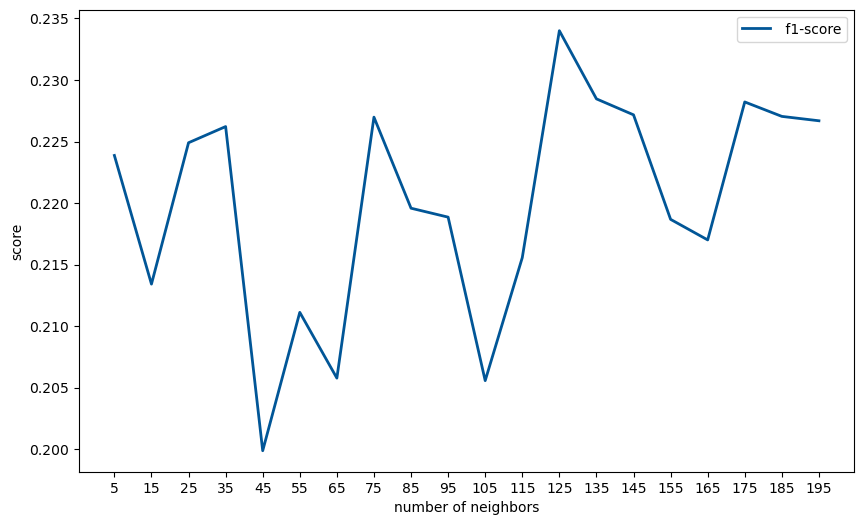

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(f1, label=' f1-score', c=colors[1], lw=2)

neighbors_range = list(range(5, 200, 10))
plt.xticks(range(len(neighbors_range)), neighbors_range)
#plt.title('Classification Performance for Different Values of k')
plt.xlabel('number of neighbors')
plt.ylabel('score')
plt.legend()
plt.show()

In [110]:
y_train.value_counts()

popularity_binary
0    30546
1     1283
Name: count, dtype: int64

In [112]:
y_train_resampled.value_counts()

popularity_binary
0    30546
1    30546
Name: count, dtype: int64

In [47]:
# use DT score to tuning smote parameter
from imblearn.pipeline import Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=123)),
    ('dt', DecisionTreeClassifier(random_state=123))
])

In [98]:
param_grid = {
    'smote__k_neighbors': [3, 5, 7, 9, 11, 13]  # tuning n_neighbors 
    
}

In [51]:
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
scoring = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

In [100]:
grid_search_S = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_S.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1, param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 13]},
             scoring='accuracy')

In [106]:
grid_search_S.best_params_

{'smote__k_neighbors': 3}

In [102]:
eval(grid_search_S,X_test, y_train, y_test)

Accuracy: 0.9224397038340297
Train Accuracy 0.9999685821106538
Train F1-score [0.99998363 0.99961014]

Test Accuracy 0.9224397038340297
Test F1-score [0.95907473 0.26013986]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13134
           1       0.20      0.37      0.26       507

    accuracy                           0.92     13641
   macro avg       0.59      0.66      0.61     13641
weighted avg       0.95      0.92      0.93     13641



In [69]:
# use to plot
grid_search_p = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, return_train_score=True)
grid_search_p.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1, param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 13]},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [71]:
results = grid_search.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_smote__k_neighbors', 'params', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1', 'split2_train_f1', 'split3_train_f1', 'split4_train_f1', 'mean_train_f1', 'std_train_f1', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_train_recall', 'split1_train_recall', 'split2_train_recall', 'split3_train_recall', 'split4_train_recall', 'mean_train_recall', 'std_train_recall', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_train_precision', 'split1_train_precision', 'split2_train_precision', 'split3_train_precis

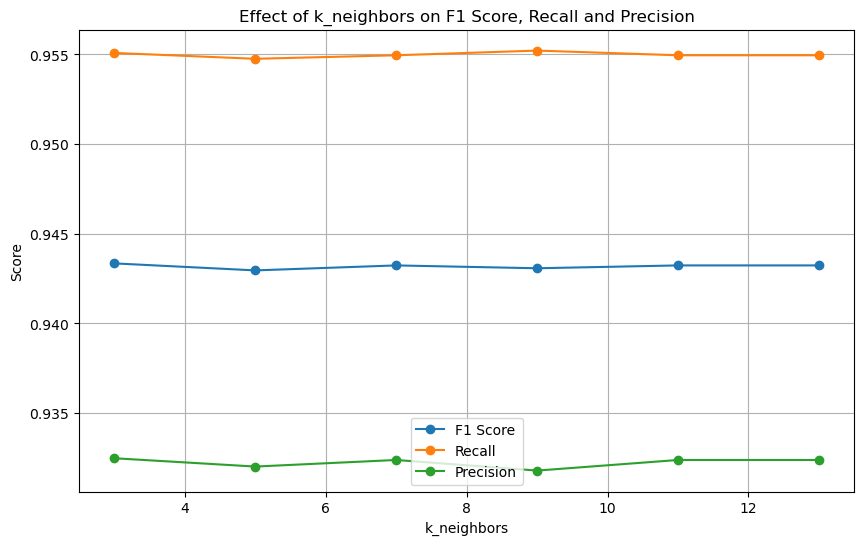

In [73]:
# get k_neighbors value
k_values = param_grid['smote__k_neighbors']

# get scores
f1_scores = results['mean_test_f1']
recall_scores = results['mean_test_recall']
precision_scores = results['mean_test_precision']

# plot
plt.figure(figsize=(10, 6))

plt.plot(k_values, f1_scores, label='F1 Score', marker='o')
plt.plot(k_values, recall_scores, label='Recall', marker='o')
plt.plot(k_values, precision_scores, label='Precision', marker='o')

plt.title('Effect of k_neighbors on F1 Score, Recall and Precision')
plt.xlabel('k_neighbors')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# tuning dt parmater use best k_neighbors = 3
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']  
    
}

In [130]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

/Users/yian/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]},
             scoring='accuracy')

In [132]:
eval(grid_search,X_test, y_train, y_test)

Accuracy: 0.9201671431713218
Train Accuracy 0.9925225423356059
Train F1-score [0.9960899  0.91469534]

Test Accuracy 0.9201671431713218
Test F1-score [0.95776614 0.27254509]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     13134
           1       0.21      0.40      0.27       507

    accuracy                           0.92     13641
   macro avg       0.59      0.67      0.62     13641
weighted avg       0.95      0.92      0.93     13641



## under-sampleing

CNN (Condensed Nearest Neighbor)

In [117]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [115]:
# 只对训练集进行随机采样
X_train_sampled, y_train_sampled = resample(X_train, y_train, 
                                            replace=False,  # 不替换
                                            n_samples=int(len(X_train) * 0.1),  # 采样50%
                                            random_state=123)

In [118]:
X_train

,track_number,album_type,album_total_tracks,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo_confidence,mode_confidence,num_genres_track,genre,duration_min,album_release_year,num_artists,popularity_art,followers,num_genres_art
17913,2,0,15,0.705,0.782,-6.692,0.0379,0.017000,0.000000,0.0741,...,0.204,0.515,1,35,3.790217,2017,1,42.0,92192.0,1.0
54847,1,2,1,0.390,0.990,-1.572,0.4390,0.018800,0.000000,0.3060,...,0.124,0.406,1,49,2.532767,2018,1,47.0,25302.0,2.0
37292,11,0,11,0.538,0.553,-8.928,0.0391,0.742000,0.165000,0.1080,...,0.457,0.436,1,45,6.057100,2017,1,34.0,25076.0,1.0
55751,8,1,12,0.784,0.895,-9.533,0.0601,0.000175,0.887000,0.6460,...,0.958,0.798,1,13,8.088167,2007,1,36.0,52100.0,3.0
63847,1,2,1,0.710,0.998,-1.898,0.3040,0.022100,0.000000,0.5290,...,0.884,0.608,1,78,2.834033,2013,1,21.0,3027.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10599,13,1,25,0.716,0.487,-9.706,0.0962,0.002880,0.319000,0.7870,...,0.376,0.462,1,88,3.810883,2022,1,55.0,623608.0,3.0
25030,1,2,1,0.639,0.665,-6.736,0.3130,0.235000,0.000011,0.1620,...,0.033,0.609,1,60,2.884983,2020,1,57.0,554623.0,3.0
29839,2,0,8,0.660,0.476,-13.297,0.0482,0.901000,0.936000,0.1100,...,0.193,0.518,1,105,1.492850,2022,1,35.0,2063.0,1.0
50993,62,1,95,0.565,0.782,-5.098,0.0305,0.034100,0.000000,0.0782,...,0.877,0.438,1,19,2.769467,2022,1,71.0,4434035.0,3.0


In [129]:
%%time
cnn = CondensedNearestNeighbour()
X_res, y_res = cnn.fit_resample(X_train, y_train)

CPU times: user 1h 38min 47s, sys: 2min 3s, total: 1h 40min 51s
Wall time: 14min 31s


In [131]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4324, 1: 1258})


In [132]:
clf = DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=30, random_state=42)
clf.fit(X_res, y_res)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92     12909
           1       0.03      0.11      0.05       502

    accuracy                           0.85     13411
   macro avg       0.50      0.49      0.48     13411
weighted avg       0.93      0.85      0.88     13411



In [106]:
pipeline_cnn = Pipeline([
    ('cnn', CondensedNearestNeighbour()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [117]:
param_grid_cnn = {
    'cnn__n_neighbors': [1, 3, 5, 10, 20]
}#defaul = 1

In [119]:
grid_search_cnn = GridSearchCV(pipeline_cnn, param_grid_cnn, cv=5, scoring='accuracy', n_jobs=-1)

In [121]:
grid_search_cnn.fit(X_train_sampled, y_train_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cnn', CondensedNearestNeighbour()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1, param_grid={'cnn__n_neighbors': [1, 3, 5, 10, 20]},
             scoring='accuracy')

In [123]:
grid_search_cnn.best_params_

{'cnn__n_neighbors': 1}

In [125]:
eval(grid_search_cnn, X_train_sampled, X_test, y_train_sampled, y_test)

Test Accuracy: 0.7973755589766146
Train Accuracy 0.8290383406662476
Train F1-score [0.90282244 0.28981723]

Test Accuracy 0.7973755589766146
Test F1-score [0.88492923 0.15266708]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     13134
           1       0.09      0.49      0.15       507

    accuracy                           0.80     13641
   macro avg       0.53      0.65      0.52     13641
weighted avg       0.94      0.80      0.86     13641



under sampling cnn score（without dt parameters tuning）

In [28]:
param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [1, 5, 10, 20, 30, 40, 50]}

### cluster centroid

In [14]:
!pip install imblearn

In [15]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids

In [17]:
from collections import Counter

In [133]:
%%time
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
X_res, y_res = cc.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1258, 1: 1258})
CPU times: user 3.23 s, sys: 2.16 s, total: 5.39 s
Wall time: 799 ms


In [135]:
%%time

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [5, 10, 20, 50, 100],
             'min_samples_leaf': [5, 10, 20, 30, 40, 50],
             'min_samples_split': [5, 10, 20, 30, 40, 50]}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    refit=True,
    n_iter=200,
    random_state=42
)

random_search.fit(X_res, y_res)
clf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 100, 'criterion': 'entropy'}
CPU times: user 650 ms, sys: 214 ms, total: 864 ms
Wall time: 7.71 s


In [136]:
clf

DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=5,
                       min_samples_split=10)

Accuracy 0.39393035567817464
F1-score [0.54198129 0.1044513 ]
              precision    recall  f1-score   support

           0       0.99      0.37      0.54     12909
           1       0.06      0.94      0.10       502

    accuracy                           0.39     13411
   macro avg       0.52      0.66      0.32     13411
weighted avg       0.96      0.39      0.53     13411



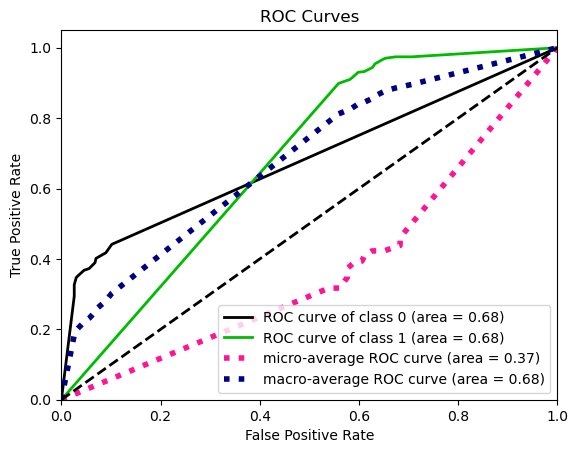

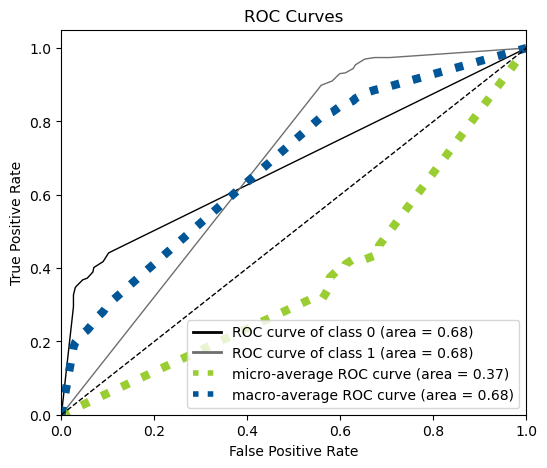

In [137]:
# fit
clf = DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)
clf.fit(X_res, y_res)

# predict
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc_cust(y_test, y_test_pred_proba)

Accuracy 0.45224069793453137
F1-score [0.60467119 0.10849515]
              precision    recall  f1-score   support

           0       0.99      0.44      0.60     12909
           1       0.06      0.89      0.11       502

    accuracy                           0.45     13411
   macro avg       0.52      0.66      0.36     13411
weighted avg       0.96      0.45      0.59     13411



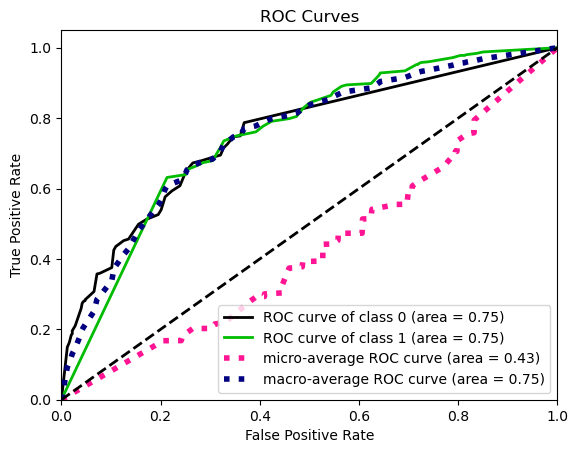

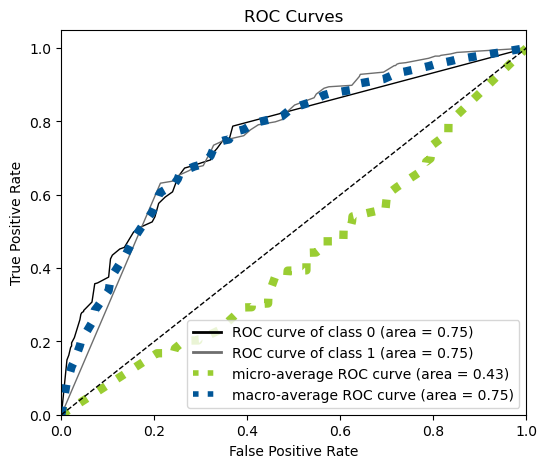

In [103]:
# fit
clf = DecisionTreeClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=30, random_state=42)
clf.fit(X_res, y_res)

# predict
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# roc
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

# roc comparison
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc_cust(y_test, y_test_pred_proba)

### ENN

In [25]:
%%time
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 27825, 1: 1258})
CPU times: user 14.6 s, sys: 177 ms, total: 14.8 s
Wall time: 4.33 s


In [130]:
len(X_train)

31292

In [52]:
%%time
count = []
accuracy = []
f1 = []
for k in range(5, 200, 10):
    enn = EditedNearestNeighbours(n_neighbors=k)
    X_res, y_res = enn.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_res))
    count += [y_res]
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X_test)

    accuracy += [accuracy_score(y_test, y_pred)]
    f1 += [f1_score(y_test, y_pred)]


Resampled dataset shape Counter({0: 26484, 1: 1258})
Resampled dataset shape Counter({0: 20750, 1: 1258})
Resampled dataset shape Counter({0: 16584, 1: 1258})
Resampled dataset shape Counter({0: 13173, 1: 1258})
Resampled dataset shape Counter({0: 10446, 1: 1258})
Resampled dataset shape Counter({0: 8939, 1: 1258})
Resampled dataset shape Counter({0: 7803, 1: 1258})
Resampled dataset shape Counter({0: 6436, 1: 1258})
Resampled dataset shape Counter({0: 5460, 1: 1258})
Resampled dataset shape Counter({0: 4255, 1: 1258})
Resampled dataset shape Counter({0: 3343, 1: 1258})
Resampled dataset shape Counter({0: 2630, 1: 1258})
Resampled dataset shape Counter({0: 2286, 1: 1258})
Resampled dataset shape Counter({0: 1991, 1: 1258})
Resampled dataset shape Counter({0: 1731, 1: 1258})
Resampled dataset shape Counter({0: 1510, 1: 1258})
Resampled dataset shape Counter({0: 1276, 1: 1258})
Resampled dataset shape Counter({1: 1258, 0: 1137})
Resampled dataset shape Counter({1: 1258, 0: 1008})
Resampl

In [92]:
import matplotlib.colors as clr
cmap = clr.LinearSegmentedColormap.from_list('custom_map', [ '#ae0c1b', 'white', '#015697'], N=256)
cmap_wb = clr.LinearSegmentedColormap.from_list('custom_map', [ 'aliceblue', '#015697'], N=256)
cmap_rb = clr.LinearSegmentedColormap.from_list('custom_map', [ '#ae0c1b', '#015697'], N=256)
cmap_bg = clr.LinearSegmentedColormap.from_list('custom_map', [ 'black', 'gainsboro'], N=256)
colors=['#ae0c1b', '#015697']

In [66]:
count[8]

0       0
1       0
2       0
3       0
4       0
       ..
6713    1
6714    1
6715    1
6716    1
6717    1
Name: popularity_binary, Length: 6718, dtype: int64

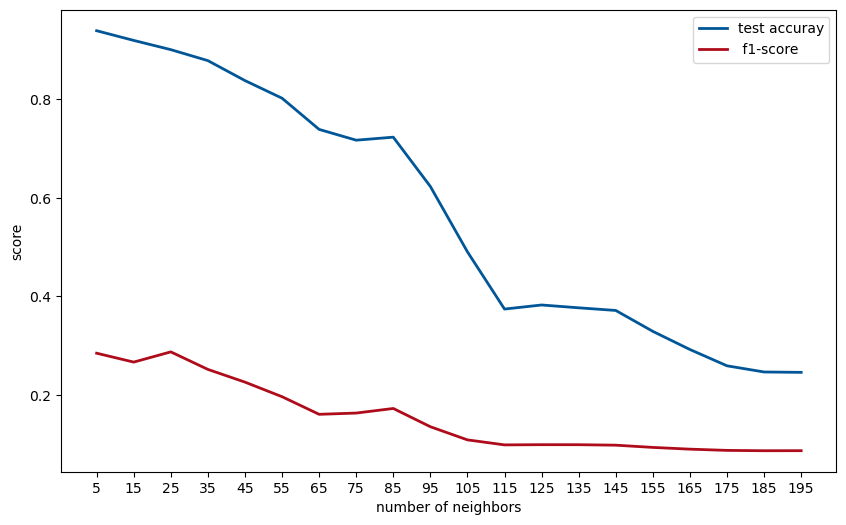

In [65]:
accuracy = []
f1 = []
for k in range(5, 200, 10):
    enn = EditedNearestNeighbours(n_neighbors=k)
    X_res, y_res = enn.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_res))
    count += [y_res]
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X_test)

    accuracy += [accuracy_score(y_test, y_pred)]
    f1 += [f1_score(y_test, y_pred)]

plt.figure(figsize=(10, 6))


plt.plot(accuracy, label='test accuray', c=colors[1], lw=2)

plt.plot(f1, label=' f1-score', c=colors[0], lw=2)

neighbors_range = list(range(5, 200, 10))
plt.xticks(range(len(neighbors_range)), neighbors_range)
#plt.title('Classification Performance for Different Values of k')
plt.xlabel('number of neighbors')
plt.ylabel('score')
plt.legend()
plt.show()

In [33]:
for k in range(100, 200, 10):
    enn = EditedNearestNeighbours(n_neighbors=k)
    X_res, y_res = enn.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 3770, 1: 1258})
Resampled dataset shape Counter({0: 3020, 1: 1258})
Resampled dataset shape Counter({0: 2459, 1: 1258})
Resampled dataset shape Counter({0: 2143, 1: 1258})
Resampled dataset shape Counter({0: 1864, 1: 1258})
Resampled dataset shape Counter({0: 1632, 1: 1258})
Resampled dataset shape Counter({0: 1371, 1: 1258})
Resampled dataset shape Counter({1: 1258, 0: 1217})
Resampled dataset shape Counter({1: 1258, 0: 1070})
Resampled dataset shape Counter({1: 1258, 0: 962})


In [34]:
list(range(100, 200, 10))

[100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

In [167]:
enn = EditedNearestNeighbours(n_neighbors=150)
X_res, y_res = enn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4631, 1: 1258})


In [36]:
param_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': [5, 10, 15, 20],
 'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
 'min_samples_split': [1, 5, 10, 20, 30, 40, 50]}

In [38]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [168]:
%%time

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [5, 10, 20, 50, 100],
             'min_samples_leaf': [5, 10, 20, 30, 40, 50],
             'min_samples_split': [5, 10, 20, 30, 40, 50]}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    refit=True,
    n_iter=200,
    random_state=42
)

random_search.fit(X_res, y_res)
clf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}
CPU times: user 914 ms, sys: 375 ms, total: 1.29 s
Wall time: 11.2 s


In [171]:
clf

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=30,
                       random_state=42)

In [172]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10, criterion='entropy', min_samples_split=5, random_state=42)
clf.fit(X_res, y_res)

# predict
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6395496234434419
F1-score [0.77129069 0.14984172]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     12909
           1       0.08      0.85      0.15       502

    accuracy                           0.64     13411
   macro avg       0.54      0.74      0.46     13411
weighted avg       0.96      0.64      0.75     13411



In [98]:
# fit
clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=5, criterion='gini', min_samples_split=30, random_state=42)
clf.fit(X_res, y_res)

# predict
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.39892625456714637
F1-score [0.54868148 0.10043522]
              precision    recall  f1-score   support

           0       0.99      0.38      0.55     12909
           1       0.05      0.90      0.10       502

    accuracy                           0.40     13411
   macro avg       0.52      0.64      0.32     13411
weighted avg       0.95      0.40      0.53     13411



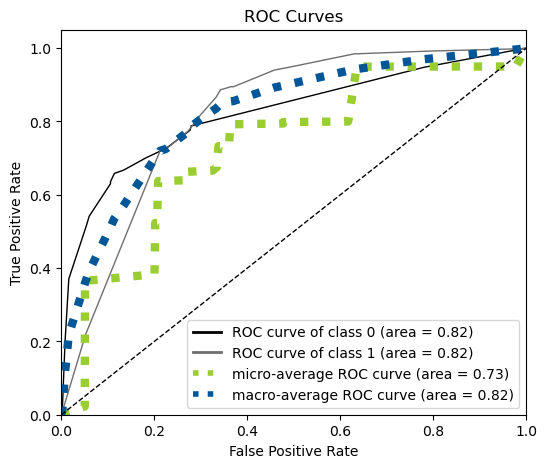

In [170]:
def plot_roc_cust(y_test, y_test_pred_proba):
    ax = plot_roc(y_test, y_test_pred_proba, figsize = (6,5),cmap=cmap_bg, plot_micro=True)
    
    for line in ax.lines:
        line.set_linewidth(1)
    
    macro = ax.lines[-2]
    macro.set_color(colors[1])
    macro.set_linewidth(6)
    
    micro = ax.lines[-3]
    micro.set_color('yellowgreen')
    micro.set_linewidth(6)
    
    legend = ax.get_legend()
    legend.legendHandles[-1].set_color(colors[1])
    legend.legendHandles[-2].set_color('yellowgreen')

    plt.show()

from scikitplot.metrics import plot_roc    
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc_cust(y_test, y_test_pred_proba)

## imbalanced data without outlier

In [62]:
X_c = df_clean_i.drop(columns=['popularity_binary','popularity_track'])  # feature
y_c = df_clean_i['popularity_binary']  # label
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.3, random_state=123)

In [180]:
dt_c = DecisionTreeClassifier()

In [182]:
param_grid_c = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

In [68]:
grid_search_c = GridSearchCV(estimator=dt_c, param_grid=param_grid_c, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_c.fit(X_train_c, y_train_c)

/Users/yian/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]},
             scoring='accuracy')

In [46]:
grid_search_c.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 2}

In [72]:
def eval(clf, X_train, X_test, y_train, y_test):

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    

    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


    print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
    print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
    print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))


    print('---------------------------------------------------------------')
    print(classification_report(y_test, y_test_pred))

In [76]:
eval(grid_search_c, X_train_c, X_test_c, y_train_c, y_test_c)

Test Accuracy: 0.9625680411602416
Train Accuracy 0.9606289147385914
Train F1-score [0.97982577 0.18733509]

Test Accuracy 0.9625680411602416
Test F1-score [0.98084408 0.18506494]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     12909
           1       0.50      0.11      0.19       502

    accuracy                           0.96     13411
   macro avg       0.73      0.55      0.58     13411
weighted avg       0.95      0.96      0.95     13411



imbalanced data without outlier score

In [80]:
from imblearn.over_sampling import SMOTE

In [82]:
# use DT score to tuning smote parameter
from imblearn.pipeline import Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=123)),
    ('dt', DecisionTreeClassifier(random_state=123))
])

In [86]:
grid_c_s = {
    'smote__k_neighbors': [3, 5, 7, 9, 11, 13]  # tuning k_neighbors 
    
}

In [88]:
grid_S_clean = GridSearchCV(pipeline, grid_c_s, cv=5, scoring='accuracy', n_jobs=-1)
grid_S_clean.fit(X_train_c, y_train_c)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1, param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 13]},
             scoring='accuracy')

In [90]:
eval(grid_S_clean, X_train_c, X_test_c, y_train_c, y_test_c)

Test Accuracy: 0.9132055775109984
Train Accuracy 0.9999360859005496
Train F1-score [0.99996671 0.99920446]

Test Accuracy 0.9132055775109984
Test F1-score [0.95405021 0.21879195]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     12909
           1       0.16      0.32      0.22       502

    accuracy                           0.91     13411
   macro avg       0.57      0.63      0.59     13411
weighted avg       0.94      0.91      0.93     13411



imbalanced data without outlier use method smote score

In [97]:
grid_c_dt = {
    'smote__k_neighbors': [3] , # tuning k_neighbors 
    'dt__max_depth': [5, 10, 15, 20],
    'dt__min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'dt__min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'dt__criterion': ['gini', 'entropy']
}

In [99]:
grid_dt_clean = GridSearchCV(pipeline, grid_c_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt_clean.fit(X_train_c, y_train_c)

/Users/yian/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=123)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [5, 10, 15, 20],
                         'dt__min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'dt__min_samples_split': [2, 5, 10, 20, 30, 40, 50,
                                                   100],
                         'smote__k_neighbors': [3]},
             scoring='accuracy')

In [101]:
eval(grid_dt_clean, X_train_c, X_test_c, y_train_c, y_test_c)

Test Accuracy: 0.9151442845425397
Train Accuracy 0.978684647833312
Train F1-score [0.98883701 0.76456054]

Test Accuracy 0.9151442845425397
Test F1-score [0.95509785 0.2300406 ]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     12909
           1       0.17      0.34      0.23       502

    accuracy                           0.92     13411
   macro avg       0.57      0.64      0.59     13411
weighted avg       0.94      0.92      0.93     13411



imbalanced data without outlier use method smote score(tuning)

In [128]:
# 只对训练集进行随机采样
X_clean_sampled, y_clean_sampled = resample(X_train_c, y_train_c, 
                                            replace=False,  # 不替换
                                            n_samples=int(len(X_train_c) * 0.1),  # 采样10%
                                            random_state=123)

In [130]:
pipeline_cnn_c= Pipeline([
    ('cnn', CondensedNearestNeighbour()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [134]:
param_grid_c = {
    'cnn__n_neighbors': [1, 3, 5, 10, 20]
}#defaul = 1

In [138]:
grid_cnn_c = GridSearchCV(pipeline_cnn_c, param_grid_c, cv=5, scoring='accuracy', n_jobs=-1)

In [140]:
grid_cnn_c.fit(X_clean_sampled, y_clean_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cnn', CondensedNearestNeighbour()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1, param_grid={'cnn__n_neighbors': [1, 3, 5, 10, 20]},
             scoring='accuracy')

In [142]:
grid_cnn_c.best_params_

{'cnn__n_neighbors': 1}

In [144]:
eval(grid_cnn_c, X_clean_sampled, X_test_c, y_clean_sampled, y_test_c)

Test Accuracy: 0.8302140034300202
Train Accuracy 0.8676893576222435
Train F1-score [0.92636073 0.3490566 ]

Test Accuracy 0.8302140034300202
Test F1-score [0.90548338 0.16623947]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     12909
           1       0.10      0.45      0.17       502

    accuracy                           0.83     13411
   macro avg       0.54      0.65      0.54     13411
weighted avg       0.94      0.83      0.88     13411



cnn method score with clean data sample(only tuning cnn)

In [150]:
# tuning decision tree
param_dt_c = {
    'cnn__n_neighbors': [1], #grid search best result = 1
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'classifier__min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'classifier__criterion': ['gini', 'entropy']
}

In [152]:
grid_dt_c = GridSearchCV(pipeline_cnn_c, param_dt_c, cv=5, scoring='accuracy', n_jobs=-1)

In [154]:
grid_dt_c.fit(X_clean_sampled, y_clean_sampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cnn', CondensedNearestNeighbour()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 15, 20],
                         'classifier__min_samples_leaf': [1, 5, 10, 20, 30, 40,
                                                          50],
                         'classifier__min_samples_split': [2, 5, 10, 20, 30, 40,
                                                           50, 100],
                         'cnn__n_neighbors': [1]},
             scoring='accuracy')

In [156]:
grid_dt_c.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 100,
 'cnn__n_neighbors': 1}

In [158]:
eval(grid_dt_c, X_clean_sampled, X_test_c, y_clean_sampled, y_test_c)

Test Accuracy: 0.9372157184400864
Train Accuracy 0.9450303611377436
Train F1-score [0.9713715 0.312    ]

Test Accuracy 0.9372157184400864
Test F1-score [0.96726792 0.23315118]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     12909
           1       0.21      0.25      0.23       502

    accuracy                           0.94     13411
   macro avg       0.59      0.61      0.60     13411
weighted avg       0.94      0.94      0.94     13411



cnn method score with clean data sample(tuning dt and cnn paramaters)

## random undersampling

In [162]:
df_clean_i.popularity_binary.value_counts()

0    42943
1     1760
Name: popularity_binary, dtype: int64

In [138]:
from imblearn.under_sampling import RandomUnderSampler

In [139]:
rus = RandomUnderSampler(random_state=123)

In [140]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [156]:
len(X_train)

31292

In [157]:
len(X_test)

13411

In [154]:
len(X_rus)

2516

In [155]:
len(y_rus)

2516

In [144]:
grid_search_rus = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rus.fit(X_rus, y_rus)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50, 100],
                         'min_samples_leaf': [5, 10, 20, 30, 40, 50],
                         'min_samples_split': [5, 10, 20, 30, 40, 50]},
             scoring='accuracy')

In [145]:
grid_search_rus

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 50, 100],
                         'min_samples_leaf': [5, 10, 20, 30, 40, 50],
                         'min_samples_split': [5, 10, 20, 30, 40, 50]},
             scoring='accuracy')

In [151]:
eval

<function __main__.eval(clf, X_test, y_train, y_test)>

In [153]:
y_train_pred = grid_search_rus.predict(X_train)
y_test_pred = grid_search_rus.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

clf.score(X_test, y_test)

print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

print('---------------------------------------------------------------')
print(classification_report(y_test, y_test_pred))

Accuracy: 0.7481172172097532
Train Accuracy 0.745270356640675
Train F1-score [0.848313   0.20568012]

Test Accuracy 0.7481172172097532
Test F1-score [0.85078187 0.19263862]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     12909
           1       0.11      0.80      0.19       502

    accuracy                           0.75     13411
   macro avg       0.55      0.77      0.52     13411
weighted avg       0.96      0.75      0.83     13411



In [186]:
eval(grid_search_rus, X_rus, X_test_c, y_rus, y_test_c)

Test Accuracy: 0.7481172172097532
Train Accuracy 0.7945151033386327
Train F1-score [0.78906569 0.79969004]

Test Accuracy 0.7481172172097532
Test F1-score [0.85078187 0.19263862]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     12909
           1       0.11      0.80      0.19       502

    accuracy                           0.75     13411
   macro avg       0.55      0.77      0.52     13411
weighted avg       0.96      0.75      0.83     13411



## random oversampling

In [190]:
from imblearn.over_sampling import RandomOverSampler

In [192]:
ros = RandomOverSampler(random_state=123)

In [194]:
X_ros, y_ros = ros.fit_resample(X_train_c, y_train_c)

In [196]:
grid_search_ros = GridSearchCV(estimator=dt_c, param_grid=param_grid_c, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_ros.fit(X_ros, y_ros)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]},
             scoring='accuracy')

In [198]:
eval(grid_search_ros, X_ros, X_test_c, y_ros, y_test_c)

Test Accuracy: 0.9193945268809186
Train Accuracy 0.9822201504961044
Train F1-score [0.98191241 0.9825176 ]

Test Accuracy 0.9193945268809186
Test F1-score [0.95734186 0.27008778]
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     12909
           1       0.20      0.40      0.27       502

    accuracy                           0.92     13411
   macro avg       0.59      0.67      0.61     13411
weighted avg       0.95      0.92      0.93     13411



In [296]:
#try sample和full data会不会影响tuning结果
X_clean_sampled, y_clean_sampled = resample(X_train_c, y_train_c, 
                                            replace=False,  # 不替换
                                            n_samples=int(len(X_train_c) * 0.1),  # 采样10%
                                            random_state=123)

In [202]:
dt_try = DecisionTreeClassifier()

In [206]:
param_grid_try = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

In [208]:
grid_search_try = GridSearchCV(estimator=dt_try, param_grid=param_grid_try, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_try.fit(X_clean_sampled, y_clean_sampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100]},
             scoring='accuracy')

In [210]:
grid_search_try.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 30,
 'min_samples_split': 2}